In [1]:
# Import relevant modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from netCDF4 import Dataset
from datetime import date, timedelta, datetime
from calendar import isleap
import math

In [34]:
# Variable for file name
file = 'co2_mbl_surface.txt'
# Open file and read lines
with open(file) as f:
    data = f.readlines()

In [35]:
# Get latitudes and convert from sin(latitude) to latitude degree in radians
sin_lats_rads = [math.asin(float(val),) for val in data[76][28:-1].split('  ')]
# Convert latitude radians to degrees
sin_lats_degs = [(val/(2*math.pi))*360 for val in sin_lats_rads]
# Print latitude degrees as a check
print(sin_lats_degs)

[-90.0, -71.80512766123321, -64.15806723683286, -58.21166938294838, -53.13010235415599, -48.590377890729144, -44.4270040008057, -40.541601873504526, -36.86989764584402, -33.36701296923175, -30.0, -26.743683950403007, -23.578178478201835, -20.487315114722662, -17.45760312372209, -14.477512185929923, -11.53695903281549, -8.626926558678639, -5.739170477266787, -2.8659839825988622, 0.0, 2.8659839825988622, 5.739170477266787, 8.626926558678639, 11.53695903281549, 14.477512185929923, 17.45760312372209, 20.487315114722662, 23.578178478201835, 26.743683950403007, 30.0, 33.36701296923175, 36.86989764584402, 40.541601873504526, 44.4270040008057, 48.590377890729144, 53.13010235415599, 58.21166938294838, 64.15806723683286, 71.80512766123321, 90.0]


In [36]:
# Make a list of the target latitudes for interpolation
target_lats = [l/10 for l in range(-895,905,10)]
# Print length of target latitude list as a check
print(target_lats)

[-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5, -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5, -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5, -9.5, -8.5, -7.5, -6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5,

In [37]:
# Get all lines of data from 80th index onwards
data_co2 = data[80:-1]
# Data is weekly and number of weeks is equal number of lines (length) in data
number_weeks = len(data_co2)
# Print number of weeks
print(number_weeks)

1488


In [39]:
### LOOP TO INTERPOLATE xCO2 DATA TO DESIRED LATITUDES ###

# Initilise empty list to store time values
times= []
# Initalise empty grid to store xCO2 values
weekly_interps = np.full((len(target_lats),1,number_weeks), fill_value=np.nan)

# Loop over lines in data
for i, line in enumerate(data_co2):
    
    # Split data in line to get values
    row_split = line.strip().replace('       ', ' ').replace('     ', ' ').split(' ')
    # Append first value to time list as this is the week measurements were taken
    times.append(row_split[0])
    
    # Get only measurements by indexing every second values (other values are standard deviations)
    values = [float(val) for val in row_split[1::2]]
    # Linearly interpolate xCO2 values to target latitudes
    interp_results = np.interp(target_lats, sin_lats_degs, values).reshape(len(target_lats),1)
    # Overwrite empty grid with interpolated values
    weekly_interps[:,:,i] = interp_results

# Print shape of interpolated values array and length of times list as a check
print(weekly_interps.shape, len(times))

(180, 1, 1488) 1488


In [40]:
### LOOP TO GET WHICH MONTH EACH MEASUREMENT LINE CORRESPONDS TO ###

# Get year by indexing first 4 positions of times
years = [int(val[0:4]) for val in times]
# Get day decimal (decimal value where day falls in year)
day_dec = [float(val[4:]) for val in times]
# Initialise empty list to store months
months = []

# Loop over years and track index with i variable
for i, year in enumerate(years):
    
    # Set reference date to 01/01/current-year
    reference_date = date(year,1,1)
    
    # Set muplitpler depending on if year is a leap year or not
    if isleap(year):
        multiplier = 366
    else:
        multiplier = 365
    
    # Get number of days since the first of the refernce year
    days_since_first = day_dec[i] * multiplier
    # Get date of this day in the year
    current_date = reference_date + timedelta(days = days_since_first)
    # Append the month of the date to month list
    months.append(current_date.month)

# Print lenght of month list as a check
print(len(months))

1488


In [41]:
# Initialise an empty array to store monthly averages
monthly_avgs = np.full((len(target_lats),1), fill_value=np.nan)
# Set start month to first month in month list
start_month = months[0]
# Set current month to start month
current_month = start_month
# Initilise empty list to store week averages
weeks_to_avg = []

# Loop over months list and track index with i
for i, m in enumerate(months):
    
    # If month in loop is equal to current month being investigated
    # append that index to weeks_to_avg list
    if m == current_month:
        weeks_to_avg.append(i)
    
    # Else if month is not equal to current month (i.e is in next month)
    else:
        # Get the mean of the current identified weeks
        monthly_avg = np.nanmean(weekly_interps[:,:,weeks_to_avg], axis=2)
        
        monthly_avg = np.flip(monthly_avg, axis=0)
        # Append this to the monthly averages array
        monthly_avgs = np.dstack((monthly_avgs, monthly_avg))
        # Reset the weeks_to_avg list to empty
        weeks_to_avg = []
        # Append the index of the present month
        weeks_to_avg.append(i)
        # Change current month to this month
        current_month = m

    # If in last index of month, loop will not go back to top for averaging
    # - this statement catches this situation
    # If on last index of months list
    if i == (len(months)-1):
        # Get mean of identified weeks
        monthly_avg = np.nanmean(weekly_interps[:,:,weeks_to_avg], axis=2)
        
        monthly_avg = np.flip(monthly_avg, axis=0)
        # Append this to monthly averages array
        monthly_avgs = np.dstack((monthly_avgs, monthly_avg))
    
# Remove first index of monthly_avgs as this just contains NaN values    
monthly_avgs = monthly_avgs[:,:,1:]

# Print monthly averages array shapeas a check
print(monthly_avgs.shape)

(180, 1, 372)


In [42]:
# Make a list of the desired longitudes
lons = [l/10 for l in range(-1795,1805,10)]
# Print length of longitudes as a check
print(len(lons))
# Repeat monthly average xCO2 across all longtudes
grid = np.tile(monthly_avgs, (1,len(lons),1))
# Print shape of array as a check
print(grid.shape)

360
(180, 360, 372)


In [43]:
# Flatten array for saving to CSV
grid_stacked = grid[:,:,0] # Get first index of array
# Loop over array indexes in time (3rd dimension)
for i in range(1,grid.shape[2]):
    grid_slice = grid[:,:,i] # Get slice of data
    grid_stacked = np.vstack((grid_stacked, grid_slice)) # Append slice to bottom of data
    
# Print flat array shape as a check
print(grid_stacked.shape)
# Save flat array to CSV
np.savetxt('xco2_mbl.csv', grid_stacked, delimiter=',')

(66960, 360)


### Adding Climatologies ###

In [48]:
# Load flat data
data = np.loadtxt('xco2_mbl.csv', delimiter=',')
# Print data shape as a check
print(data.shape)

# Get first 180 rows of data
xco2_data = data[0:180,:]
# Loop over every 180 rows of data to get monthly data
for i in range(180,len(data), 180):
    data_slice = data[i:i+180,:] # Get data slice
    xco2_data = np.dstack((xco2_data, data_slice)) # Append data to 3D array
    
# Print array shape as a check
print(xco2_data.shape)

(66960, 360)
(180, 360, 372)


In [49]:
### 2021 climatology added due to data being unavailable ###
### CORRECTION: 21/8/2022 - the climatology of xCO2 cannot be used
### due to it increasing nature over time. The climotology is maintained
### in this code because the files are used later on (with 2021 values excluded)
### but note that the section is purely for producing the necassary files and
### and the data IS NOT USED. 

# Indexes of months to average over 
months_to_avg = 12 * 15
# Get data to be used for averaging
data_to_avg = xco2_data[:,:,-months_to_avg:]
# Print shape of data as a check
print(data_to_avg.shape)

# Initialise an empty array to begin 3D of array climatology values
monthly_climatology = np.full((180,360), fill_value=np.nan)

# Loop over month indexes (0=Jan, 11=Dec)
for m in range(0,12):
    # Get all values of a given month by indexing every 12th array slice
    month_indices = [i for i in range(m,data_to_avg.shape[2],12)]
    
    # If performing Jan climatology (first iteration of loop)
    if m == 0:
        # Get all January data to average
        individual_month = data_to_avg[:,:,month_indices]
        # Get mean of January values
        month_climatology = np.nanmean(individual_month, axis=2)
        # Append January climatoloy to 3D array
        monthly_climatology = month_climatology
    # If looking at any other month
    else:
        # Get all month data to average
        individual_month = data_to_avg[:,:,month_indices]
        # Get mean of month values
        month_climatology = np.nanmean(individual_month, axis=2)
        # Append month climatology to 3D array
        monthly_climatology = np.concatenate((monthly_climatology, month_climatology), axis=0)
    
# Print final climatology array shape as a check
print(monthly_climatology.shape)

(180, 360, 180)
(2160, 360)


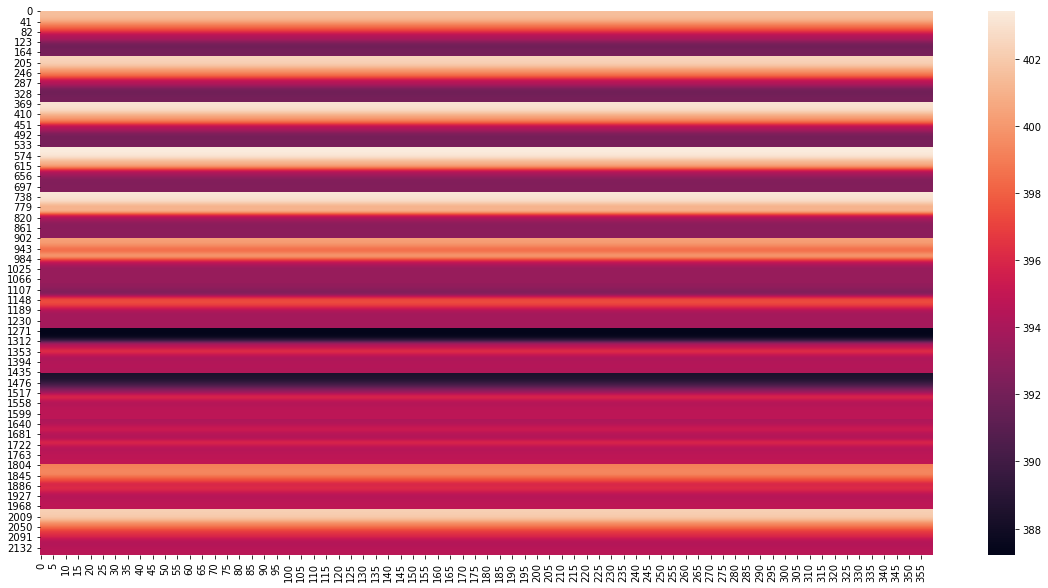

In [50]:
# Plot selection of data as a check
plt.figure(figsize=(20,10))
sns.heatmap(monthly_climatology[:,:])
plt.show()

In [51]:
# Append climatology onto end of original flattened data set
xco2_full = np.concatenate((data, monthly_climatology), axis=0)
# Get shape of complete data set as a check
print(xco2_full.shape)
# Save data to CSV file
np.savetxt('xco2_wClimatology.csv', xco2_full, delimiter=',')

(69120, 360)
